In [10]:
import pandas as pd
import pymc3 as pm

In [55]:
data = pd.read_csv("./train.tsv", sep="\t")
name = ["id", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
data_ = data[name[1:-1]].apply(lambda x: (x-x.mean())/x.std(), axis=0).fillna(0)
myX1 = data_[name[1]].iloc[1:2000,].values
myX2 = data_[name[2]].iloc[1:2000,].values
myX3 = data_[name[3]].iloc[1:2000,].values
myX4 = data_[name[4]].iloc[1:2000,].values
myX5 = data_[name[5]].iloc[1:2000,].values
myX6 = data_[name[6]].iloc[1:2000,].values
myX7 = data_[name[7]].iloc[1:2000,].values
myY = data[name[-1]].iloc[1:2000,].values

In [57]:
with pm.Model() as model2:
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1, shape=len(name)-2)
    # Expected value of outcome
    mu = intercept + beta[0]*myX1 + beta[1]*myX2 + beta[2]*myX3 + beta[3]*myX4 + beta[4]*myX5 + beta[6]*myX7
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=1, observed=myY)

In [58]:
from scipy import optimize
with model2:
    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = pm.NUTS(scaling=start)
    # draw 500 posterior samples
    trace = pm.sample(20000, step, start=start)

C:\Users\yt\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -7,232.6:  32%|███████████▊                         | 1600/5000 [00:01<00:03, 1090.82it/s]

Optimization terminated successfully.
         Current function value: 7232.626764
         Iterations: 16
         Function evaluations: 1610


logp = -7,232.6:  32%|███████████▉                         | 1610/5000 [00:01<00:03, 1060.72it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept]
100%|██████████████████████████████████████████████████████| 20500/20500 [04:04<00:00, 83.95it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E67B9E66A0>,
      dtype=object)

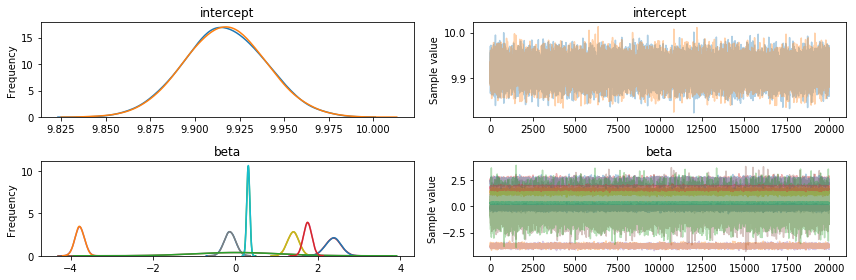

In [59]:
pm.traceplot(trace)

In [60]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,9.916297,0.022838,0.000105,9.871419,9.960844,49132.484786,0.999993
beta__0,-0.135025,0.136084,0.001006,-0.400544,0.133783,14308.812601,1.000051
beta__1,1.400748,0.137781,0.000999,1.133109,1.673077,14182.210605,1.000097
beta__2,0.312203,0.035980,0.000148,0.239387,0.380165,49761.388585,1.000012
beta__3,2.370846,0.184679,0.001573,2.011288,2.733642,11842.351917,1.000008
beta__4,-3.778335,0.113615,0.000899,-4.001725,-3.555891,13674.959947,0.999976
beta__5,-0.002432,0.993116,0.004253,-1.964675,1.936074,49961.868770,0.999975
beta__6,1.752195,0.098343,0.000752,1.560615,1.944738,14956.027445,1.000065


In [84]:
W = [pm.summary(trace)["mean"][i] for i in range(len(name) - 1)]
print("Rings = intercept + beta__0*Length + beta__1*Diameter + beta__2*Height + beta__3*Whole weight + beta__4*Shucked weight + beta__5*Viscera weight + beta__6*Shell weight")
print("Rings = {0} + {1}*Length + {2}*Diameter + {3}*Height + {4}*Whole weight + {5}*Shucked weight + {6}*Viscera weight + {7}*Shell weight".format(W[0],W[1],W[2],W[3],W[4],W[5],W[6],W[7]))

Rings = intercept + beta__0*Length + beta__1*Diameter + beta__2*Height + beta__3*Whole weight + beta__4*Shucked weight + beta__5*Viscera weight + beta__6*Shell weight
Rings = 9.91629653792091 + -0.13502505941114018*Length + 1.400748451100786*Diameter + 0.3122034951779126*Height + 2.3708456292221567*Whole weight + -3.778335293125761*Shucked weight + -0.0024319750386592744*Viscera weight + 1.7521947645495406*Shell weight


In [87]:
import statsmodels.api as sm
X_all = sm.add_constant(data_[name[1:8]].iloc[1:2000,:].values)
myY = data[name[-1]].iloc[1:2000,].values
model1 = sm.OLS(myY, X_all)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     299.7
Date:                Thu, 02 Aug 2018   Prob (F-statistic):          1.25e-305
Time:                        21:24:00   Log-Likelihood:                -4496.4
No. Observations:                1999   AIC:                             9009.
Df Residuals:                    1991   BIC:                             9054.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9212      0.051    192.956      0.000       9.820      10.022
x1            -0.0182      0.318     -0.057      0.954      -0.642       0.606
x2             1.3653      0.321      4.248      0.000       0.735       1.996
x3             0.3346      0.083      4.045      0.000       0.172       0.497
x4             4.1900      0.554      7.557      0.000       3.103       5.277
x5            -4.2500      0.279    -15.251      0.000      -4.797      -3.704
x6            -1.0551      0.212     -4.986      0.000      -1.470      -0.640
x7             1.2975      0.246      5.269      0.000       0.815       1.780
==============================================================================
Omnibus:                      504.736   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1508.781
Skew:                           1.280   Prob(JB):                         0.00
Kurtosis:                       6.400   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
re1, re2 = 0.0, 0.0
for i in range(2000, data[name[1]].iloc[1:,].values.shape[0]+1):
    myX1 = data_[name[1]].iloc[i:i+1,].values
    myX2 = data_[name[2]].iloc[i:i+1:,].values
    myX3 = data_[name[3]].iloc[i:i+1:,].values
    myX4 = data_[name[4]].iloc[i:i+1:,].values
    myX5 = data_[name[5]].iloc[i:i+1:,].values
    myX6 = data_[name[6]].iloc[i:i+1:,].values
    myX7 = data_[name[7]].iloc[i:i+1:,].values
    y = data[name[-1]].iloc[i:i+1:,].values
    
    re1 += abs(y - (9.9212 + -0.0182*myX1 + 1.3653*myX2 + 0.3346*myX3 + 4.1900*myX4 + -4.2500*myX5 + -1.0551*myX6 + 1.2975*myX7))**2
    re2 += abs(y - (W[0] + W[1]*myX1 + W[2]*myX2 + W[3]*myX3 + W[4]*myX4 + W[5]*myX5 + W[6]*myX6 + W[7]*myX7))**2
print("OLS Score  : {0}".format(re1[0]))
print("Pymc Score : {0}".format(re2[0]))

OLS Score  : 467.87686347857164
Pymc Score : 463.11764880106847
